In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [151]:
import seaborn as sns

In [ ]:
dfd = pd.read_csv(r'C:\Users\arceb\PycharmProjects\pythonProject/demandeurs_2_revenus.csv', index_col = 0)

In [ ]:
dfd=dfd.rename(columns={'Type de ressource\n': 'Type'})
dfd

In [ ]:
dfd['Ressources mensuelles\n'].isna().sum()

In [ ]:
dfdbis=dfd.drop_duplicates(subset ="Numéro Unique")
dfdbis=dfdbis.dropna()
dfdbis

### Calcul des ressources imposables mensuelles

In [ ]:
values=["Retraite", "Allocation chômage / indemnités", "Salaire ou revenu d'activité", "Pension alimentaire reçue", "Autres (hors APL ou AL)", "Pension d\'invalidité"]
filtered_df = dfd[dfd.Type.isin(values)]
filtered_df

In [ ]:
shrank_values = filtered_df.groupby(by='Numéro Unique').sum()['Montant par type de ressource\n']

merged_df = filtered_df.merge(shrank_values, left_on='Numéro Unique', right_index=True)

merged_df = merged_df.rename(columns={'Montant par type de ressource\n_y': 'Ressources imposables mensuelles moyennes (RI)'})


In [ ]:
merged_df

In [ ]:
merged_dfbis=merged_df.drop_duplicates(subset ="Numéro Unique")
merged_dfbis

In [ ]:
bdd = dfdbis.merge(merged_dfbis, on='Numéro Unique', how='outer')
bdd=bdd[['Numéro Unique', 'Ressources mensuelles\n_x','Ressources imposables mensuelles moyennes (RI)']]
bdd=bdd.rename(columns={'Ressources mensuelles\n_x': 'RM Moyennes'})
bdd

In [ ]:
#Foyers dont les ressources mensuelles ne matchent pas le revenu imposable => Une part des ressources n'est pas imposable
merged_df[merged_df['Revenu imposable']!=merged_df['Ressources mensuelles']]

In [ ]:
#Foyers avec plusieurs type de revenus
merged_df[merged_df['Revenu imposable']!=merged_df['Montant par type de ressource_x']]


In [ ]:
#Foyers avec un seul type de revenu
merged_df[~(merged_df['Revenu imposable']!=merged_df['Montant par type de ressource_x'])]


### Calcul des prestations familiales et sociales mensuelles

In [ ]:
values1=["Allocation d'adulte handicapé(AAH)", "Allocation d'éducation d'enfant handicapé (AEEH)", "Allocation de minimum vieillesse", "Allocation familiales", "Allocation Jeune Enfant (PAJE)", "Bourse étudiant", "Prime d'activité", "Revenu de solidarité active (RSA)", "Allocation journalière de présence parentale (AJPP)"]
filtered_df1 = dfd[dfd.Type.isin(values1)]
filtered_df1

In [ ]:
shrank_values1 = filtered_df1.groupby(by='Numéro Unique').sum()['Montant par type de ressource\n']

merged_df1 = filtered_df1.merge(shrank_values1, left_on='Numéro Unique', right_index=True)

merged_df1 = merged_df1.rename(columns={'Montant par type de ressource\n_y': 'Prestations familiales et sociales mensuelles moyennes (PFS)'})

In [ ]:
merged_df1

In [ ]:
merged_dfbis1=merged_df1.drop_duplicates(subset ="Numéro Unique")
merged_dfbis1

In [ ]:
bddbis = bdd.merge(merged_dfbis1, on='Numéro Unique', how='outer')
bddbis=bddbis.rename(columns={'Ressources mensuelles\n_x': 'RM Moyennes'})
bddbis=bddbis[['Numéro Unique', 'RM Moyennes','Ressources imposables mensuelles moyennes (RI)', 'Prestations familiales et sociales mensuelles moyennes (PFS)']]
bddbis

In [ ]:
bddbis['Ressources imposables mensuelles moyennes (RI)'].isna().sum()

In [ ]:
bddbis['Prestations familiales et sociales mensuelles moyennes (PFS)'].isna().sum()

### Somme Revenus imposables et prestations

In [ ]:
bddbis['Ressources imposables mensuelles moyennes (RI)'].fillna(0, inplace=True)
bddbis['Prestations familiales et sociales mensuelles moyennes (PFS)'].fillna(0, inplace=True)

In [ ]:
bddbis

In [ ]:
bddbis['Ri + PFS']=bddbis['Ressources imposables mensuelles moyennes (RI)']+bddbis['Prestations familiales et sociales mensuelles moyennes (PFS)']
bddbis

In [ ]:
file_name = 'RI_PFS_IDF.csv'
bddbis.to_csv(file_name)

### Mise en place des tranches de ressources mensuelles

In [ ]:
bddbis['Tranches de ressources mensuelles (RM)']=0

def decoupe(rl):
    for i in range(0, 5000, 50):
        if i<=rl and rl<i+50:
            return i
        elif rl>4950:
            return 4950

bddbis['Tranches de ressources mensuelles (RM)'] = bddbis['RM Moyennes'].apply(decoupe)
bddbis

In [ ]:
#bddbis['Tranches de ressources mensuelles'].dropna()

In [ ]:
#bddbis.groupby(['Tranches de ressources mensuelles'])['Sales'].mean()
x=bddbis.groupby('Tranches de ressources mensuelles (RM)').mean().reset_index()
x

In [ ]:
#x['Nombre de demandeurs'] = bddbis.groupby('Tranches de ressources mensuelles').count()
y=bddbis['Tranches de ressources mensuelles (RM)'].value_counts()
y=y.reset_index()
y

In [ ]:
y=y.rename(columns={'index': 'Tranches de ressources mensuelles (RM)', "Tranches de ressources mensuelles (RM)": "Nombre de demandeurs"})

In [ ]:
y

In [ ]:
final = x.merge(y, on='Tranches de ressources mensuelles (RM)', how='left')
final

In [ ]:
final=final[['Tranches de ressources mensuelles (RM)', 'Nombre de demandeurs', 'RM Moyennes', 'Prestations familiales et sociales mensuelles moyennes (PFS)', 'Ressources imposables mensuelles moyennes (RI)', 'Ri + PFS']]

In [ ]:
final=final.reset_index(drop=True)
final

In [ ]:
#file_name = 'Analyse des ressources v4.xlsx'
#final.to_excel(file_name)

### Tableaux croisés RI / PFS

In [ ]:
bddbis['Tranches de RI']=0
bddbis['Tranches de PFS']=0

def decoupe2(rl):
    for i in range(0, 2000, 50):
        if i<rl and rl<=i+50:
            return i
        elif rl>2000:
            return np.NaN
        elif rl==0:
            return np.NaN


bddbis['Tranches de RI'] = bddbis['Ressources imposables mensuelles moyennes (RI)'].apply(decoupe2)
bddbis['Tranches de PFS'] = bddbis['Prestations familiales et sociales mensuelles moyennes (PFS)'].apply(decoupe2)
bddbis

In [ ]:
tableau=bddbis[['Tranches de RI', 'Tranches de PFS']]
tableau=tableau.dropna()
tableau

In [ ]:
#bddbis.pivot_table(index="Trancges de RI", columns="Tranches de PFS", values="value", aggfunc="sum")
z=bddbis.pivot_table(index="Tranches de RI", columns="Tranches de PFS", values="Numéro Unique",  aggfunc="size", fill_value=0)
z

In [ ]:
file_name = 'Tableau croisé non nul v2.xlsx'
z.to_excel(file_name)

In [ ]:
bddbis[bddbis['Tranches de PFS']==0]

In [ ]:
shrank = tableau.groupby(by='Tranches de RI').count()['Tranches de PFS']
shrank

In [ ]:
import plotly.graph_objects as go

In [ ]:
fig=go.Figure(go.Surface(z=z, y=z.index, x=z.columns))
fig.show()

In [ ]:
fig.write_html(r"C:\Users\arceb\pythonProjects\Graphique.html")

In [ ]:
import plotly.express as px

In [ ]:
fig2=px.scatter(z)

In [ ]:
fig3=px.imshow(z)

In [ ]:
fig2.write_html(r"C:\Users\arceb\PycharmProjects\Graphique_bis.html")

In [ ]:
fig3.write_html(r"C:\Users\arceb\PycharmProjects\Graphique3.html")

In [ ]:
import plotly

### Graphiques RI nuls

In [ ]:
RI=bddbis[bddbis['Ressources imposables mensuelles moyennes (RI)']==0]

In [ ]:
RI

In [ ]:
RI['Tranches de PFS']=0

def ri(rl):
    for i in range(0, 2000, 50):
        if i<rl and rl<=i+50:
            return i
        elif rl>2000:
            return np.NaN

RI['Tranches de PFS'] = RI['Prestations familiales et sociales mensuelles moyennes (PFS)'].apply(ri)
RI

In [ ]:
ri=RI[['Tranches de PFS', 'Numéro Unique']]
ri

In [ ]:
ri = ri.groupby(by='Tranches de PFS').count()['Numéro Unique']
ri = ri.to_frame()
ri

In [ ]:
ri['Numéro Unique'].sum()

In [ ]:
ri=ri.reset_index()

In [ ]:
ri['Numéro Unique']=(ri['Numéro Unique']/14545)*100
ri

In [ ]:
ri['Numéro Unique'].sum()

In [ ]:
 ax = ri.plot.bar(x='Tranches de PFS', y='Numéro Unique', xlabel='Tranche de Prestations sociales et financières', ylabel= "Pourcentage de demandeurs", title= 'Distribution par montant de PFS des demandeurs qui ne déclarent aucun RI', rot=0, figsize=(25,5), color='red')

In [52]:
ax.figure.savefig('PFS_Aix.pdf')

### Graphiques PFS nuls

In [53]:
PFS=bddbis[bddbis['Prestations familiales et sociales mensuelles moyennes (PFS)']==0]

In [54]:
PFS['Tranches de RI']=0

def pfs(rl):
    for i in range(0, 2000, 50):
        if i<rl and rl<=i+50:
            return i
        elif rl>2000:
            return np.NaN

PFS['Tranches de RI'] = PFS['Ressources imposables mensuelles moyennes (RI)'].apply(pfs)
PFS

C:\Users\arceb\AppData\Local\Temp\ipykernel_22328\2495171306.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\arceb\AppData\Local\Temp\ipykernel_22328\2495171306.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Numéro Unique,RM Moyennes,Ressources imposables mensuelles moyennes (RI),Prestations familiales et sociales mensuelles moyennes (PFS),Ri + PFS,Tranches de ressources mensuelles (RM),Tranches de RI,Tranches de PFS
0,0010217076044GDPUB,1890.0,1890.0,0.0,1890.0,1850.0,1850.0,NaN
1,001031606377111126,1550.0,1550.0,0.0,1550.0,1550.0,1500.0,NaN
10,0010617081725AL002,418.0,418.0,0.0,418.0,400.0,400.0,NaN
11,001071505384511126,560.0,560.0,0.0,560.0,550.0,550.0,NaN
12,0010716067636GDPUB,1600.0,1600.0,0.0,1600.0,1600.0,1550.0,NaN
...,...,...,...,...,...,...,...,...
77720,9740117135655GDPUB,500.0,500.0,0.0,500.0,500.0,450.0,NaN
77722,9740617145543GDPUB,2150.0,2150.0,0.0,2150.0,2150.0,NaN,NaN
77724,974061714677811483,806.0,806.0,0.0,806.0,800.0,800.0,NaN
77727,9741217157742GDPUB,359.0,359.0,0.0,359.0,350.0,350.0,NaN


In [55]:
pfs=PFS[['Tranches de RI', 'Numéro Unique']]
pfs = pfs.groupby(by='Tranches de RI').count()['Numéro Unique']
pfs = pfs.to_frame()

In [56]:
pfs['Numéro Unique'].sum()

35989

In [57]:
pfs=pfs.reset_index()
pfs['Numéro Unique']=(pfs['Numéro Unique']/35989)*100
pfs

,Tranches de RI,Numéro Unique
0,0.0,0.086137
1,50.0,0.119481
2,100.0,0.197283
3,150.0,0.172275
4,200.0,0.141710
5,250.0,0.269527
6,300.0,0.347328
7,350.0,0.461252
8,400.0,0.414015
9,450.0,2.011726


In [58]:
pfs['Numéro Unique'].sum()

100.0

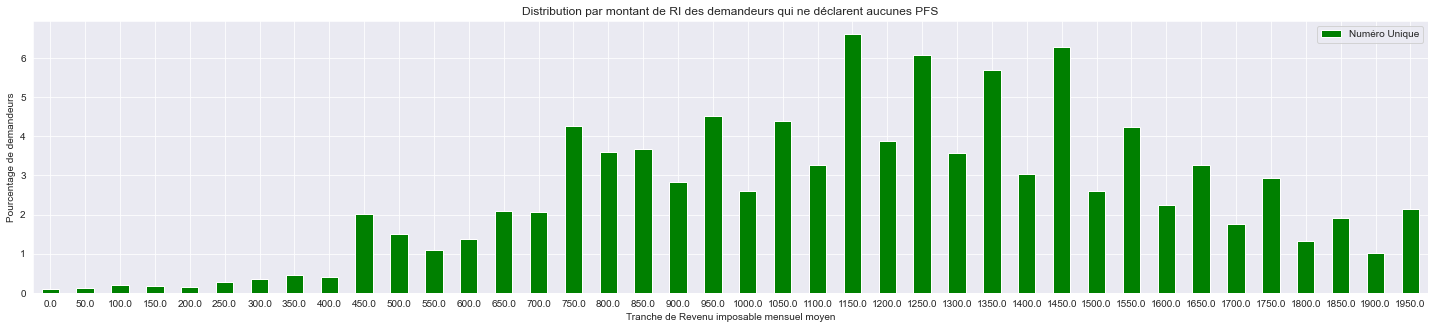

In [59]:
 ax = pfs.plot.bar(x='Tranches de RI', y='Numéro Unique', xlabel='Tranche de Revenu imposable mensuel moyen', ylabel= "Pourcentage de demandeurs", title= 'Distribution par montant de RI des demandeurs qui ne déclarent aucunes PFS', rot=0, figsize=(25,5), color='green')

In [60]:
ax.figure.savefig('RI_Aix.pdf')